In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from porespy import generators
from tomo_encoders.misc_utils.feature_maps_vis import view_midplanes
import cupy as cp
import time
import h5py
from tomopy import project
sys.path.append('/data02/MyArchive/aisteer_3Dencoders/TomoEncoders/tomo_encoders/tasks/sparse_segmenter/')
from recon_subvol import fbp_filter, recon_patch
from ct_segnet.data_utils.data_io import DataFile
import os
import signal
import tomocg as pt

In [2]:
# # Use managed memory
# cp.cuda.set_allocator(cp.cuda.MemoryPool(cp.cuda.malloc_managed).malloc)

### Read projections data  

In [3]:
filename = 'mli_L206_HT_650_L3'
projs_path = '/data02/MyArchive/AM_part_Xuan/projs' 
binning = 1 
ntheta = 4201

In [4]:
read_fpath = os.path.join(projs_path, filename + '_projs_bin%i_ntheta%i.hdf5'%(binning,ntheta))
with h5py.File(read_fpath, 'r') as hf:
    projs = np.asarray(hf['data'][:])
    theta = np.asarray(hf['theta'][:])
    center = float(np.asarray(hf['center'][()]))

projections shape: (4201, 1102, 4200)


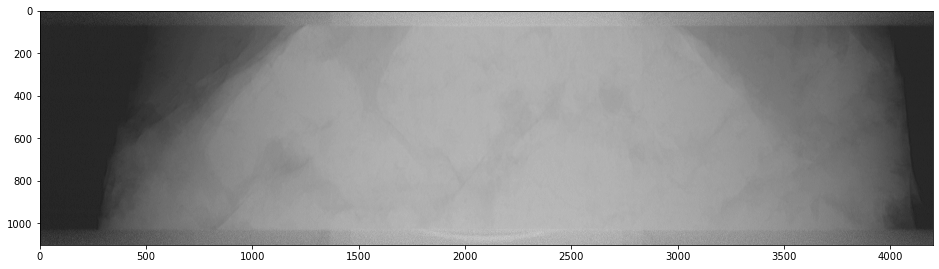

In [5]:
print("projections shape: %s"%str(projs.shape))
fig, ax = plt.subplots(1,1, figsize = (16,8))
ax.imshow(projs[0], cmap = 'gray')

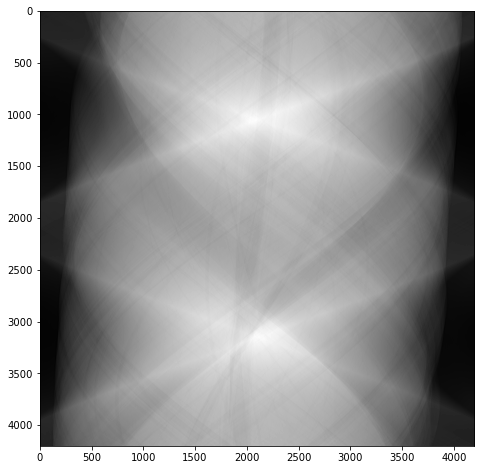

In [6]:
fig, ax = plt.subplots(1,1, figsize = (16,8))
ax.imshow(projs[:,500,:], cmap = 'gray')

### Reconstruct part

In [7]:
binning

1

## Reconstruct one full slice  

In [8]:
projs.shape

(4201, 1102, 4200)

In [9]:
projs.shape

(4201, 1102, 4200)

In [10]:
binning

1

In [11]:
projs.shape

(4201, 1102, 4200)

In [12]:
# cp.get_default_memory_pool().free_all_blocks()


In [16]:
# point = [500//binning, 0, 0]
# point = [0, 0, 0]
# width = [1, 4200//binning, 4200//binning]


# z, y, x
# point = [0, 2000//binning, 2000//binning]
# width = [128, 512, 512]

center = projs.shape[-1]//2.0
point = [500, 0, 0]
width = [1, 2100, 2100]


with cp.cuda.Device(0):
    center = projs.shape[-1]//2.0
    sub_vol = recon_patch(projs, theta, center, point, width, mem_limit_gpu = 40.0, apply_fbp=True)
    sub_vol = 1.0*(sub_vol - sub_vol.min()) / (sub_vol.max() - sub_vol.min())

(4201, 1, 5256)
0.4227132797241211


In [17]:
sub_vol.shape

(1, 2100, 2100)

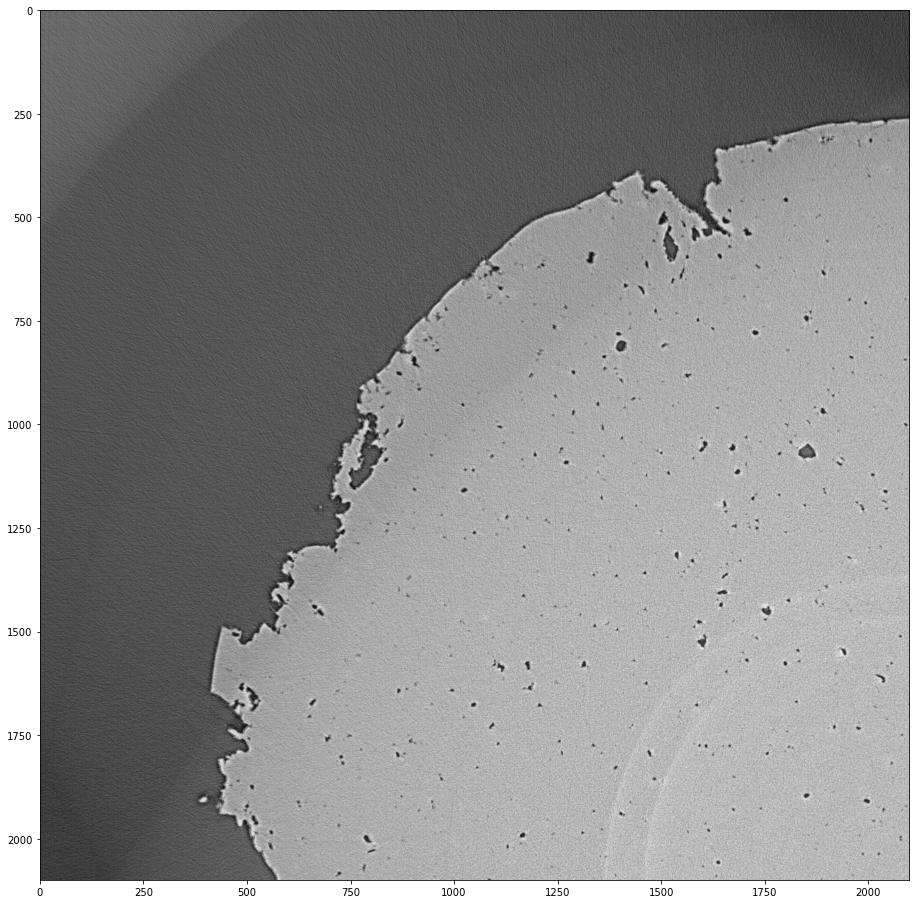

In [18]:
fig, ax = plt.subplots(1,1, figsize = (16,16))
ax.imshow(sub_vol[0], cmap = 'gray')

### Reconstruct slabs  

In [20]:
# point is the corner value z, y, x and width is the width of box. this will be fed from detection part
point = [400//binning, 2000//binning, 2000//binning]
width = [128//binning, 256//binning, 256//binning]

In [21]:
sub_vol = recon_patch(projs, theta, center, point, width, mem_limit_gpu = 40.0)

(4201, 128, 5256)
0.4903371334075928


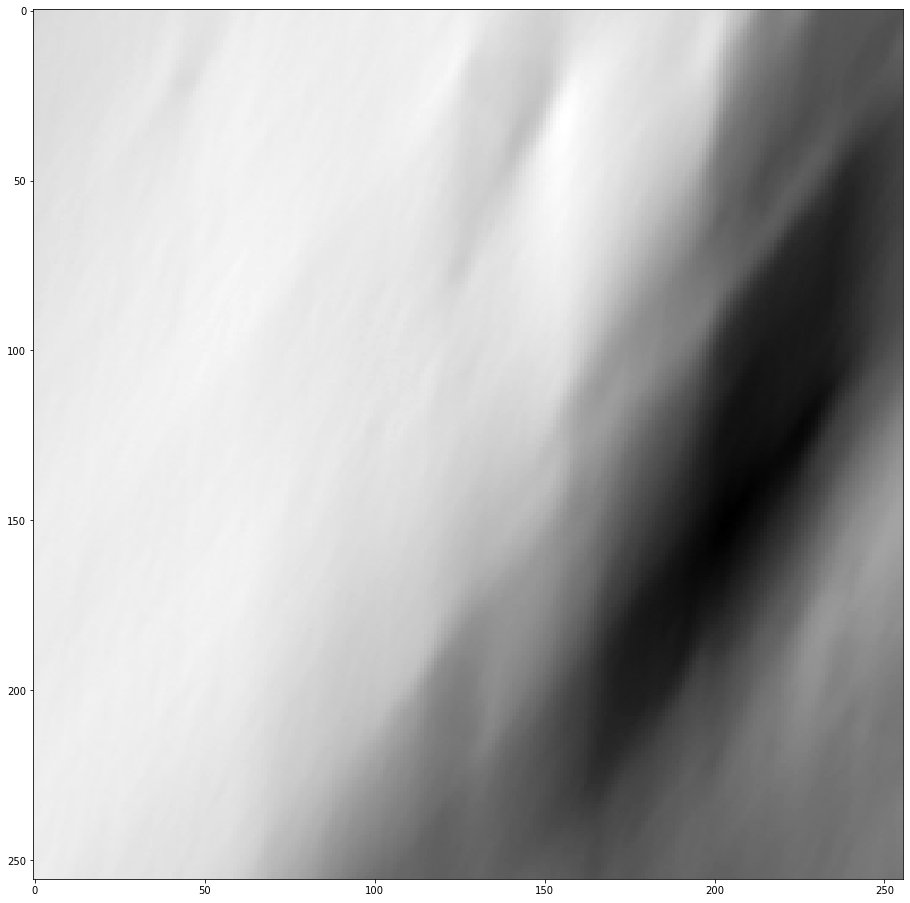

In [22]:
fig, ax = plt.subplots(1,1, figsize = (16,16))
ax.imshow(sub_vol[0], cmap = 'gray')

In [23]:
sub_vol.shape

(128, 256, 256)

array([<AxesSubplot:title={'center':'XY mid-plane'}>,
       <AxesSubplot:title={'center':'XZ mid-plane'}>,
       <AxesSubplot:title={'center':'YZ mid-plane'}>], dtype=object)

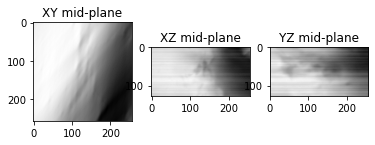

In [24]:
view_midplanes(sub_vol)

### Reconstruct cube  

In [21]:
# point is the corner value z, y, x and width is the width of box. this will be fed from detection part
point = [400//binning, 2000//binning, 2000//binning]
width = [256//binning, 256//binning, 256//binning]
vol.shape

(551, 2100, 2100)

In [22]:
sub_vol = recon_patch(projs, theta, center, point, width, mem_limit_gpu = 40.0)
# sub_vol = 2.0*(sub_vol - sub_vol.min()) / (sub_vol.max() - sub_vol.min())

0.07354521751403809


array([<AxesSubplot:title={'center':'XY mid-plane'}>,
       <AxesSubplot:title={'center':'XZ mid-plane'}>,
       <AxesSubplot:title={'center':'YZ mid-plane'}>], dtype=object)

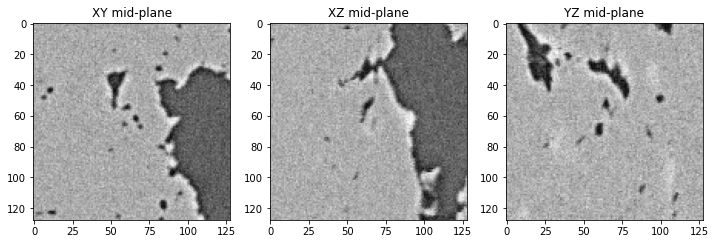

In [23]:
fig, ax = plt.subplots(1, 3, figsize = (12,6))
view_midplanes(sub_vol, ax = ax)

In [24]:
# slices = tuple([slice(point[ii], point[ii] + width[ii]) for ii in range(3)])
# vol[slices] = sub_vol

In [25]:
# fig, ax = plt.subplots(1, 3, figsize = (12,6))
# view_midplanes(vol, ax = ax, idxs = [point[j] + width[j]//2 for j in range(3)])

## TRASHED  

In [26]:
# CHECK PROJECTIONS
# theta_vals = np.random.choice(theta, 16, replace = True)
# fig, ax = plt.subplots(2,2, figsize = (16,8))
# fig.suptitle('binning = %i'%binning, fontsize = 24)
# for ii in range(4):
#     idx = np.argmin(np.abs(theta_vals[ii] - theta))
#     ax.flat[ii].imshow(projs[idx], cmap = 'gray')
#     ax.flat[ii].set_title('theta = %.3f'%theta_vals[ii])    
#     print(f'error={cp.linalg.norm(projs1[::2,::2,::2]-projs2)/cp.linalg.norm(projs2)}')
    
# fig.tight_layout()